### Testing Evo

#### Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch_geometric
from torch_geometric.nn import GCNConv
import IPython
from IPython.display import display, HTML, Image

from graphUtils import add_edges
from generator import generate_organism
from cell import Cell
from organism import Organism
from GNCAmodel import GNCA
from visualizer import Visualizer
from evo_trainer import Evo_Trainer

#%run Visualizer.py # --allows for reloading the particular code

#### Train the network

In [2]:
n = 10
popsize = 10
generations = 300
wrap_around = True
name = 'centered8'
#device = torch.device('mps:0')
device = torch.device('cpu')
#trainer = Evo_Trainer(n, device)
trainer = Evo_Trainer(n, device, popsize)

2023-02-21 16:51:38,855	INFO worker.py:1528 -- Started a local Ray instance.


[2023-02-21 16:51:41] INFO     <37002> evotorch.core: Instance of `Custom_NEProblem` (id:4377660528) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-02-21 16:51:41] INFO     <37002> evotorch.core: Instance of `Custom_NEProblem` (id:4377660528) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-02-21 16:51:41] INFO     <37002> evotorch.core: Instance of `Custom_NEProblem` (id:4377660528) -- The `device` of the problem is set as cpu
[2023-02-21 16:51:41] INFO     <37002> evotorch.core: Instance of `Custom_NEProblem` (id:4377660528) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-02-21 16:51:41] INFO     <37002> evotorch.core: Instance of `Custom_NEProblem` (id:4377660528) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [3]:
trainer.train(generations, name)

         iter : 1
     stepsize : ReadOnlyTensor(0.0998)
  median_eval : -399.80364990234375
pop_best_eval : -395.7060546875
    mean_eval : -399.5158996582031

         iter : 2
     stepsize : ReadOnlyTensor(0.0996)
  median_eval : -399.8221130371094
pop_best_eval : -394.290771484375
    mean_eval : -399.2869873046875

         iter : 3
     stepsize : ReadOnlyTensor(0.0994)
  median_eval : -399.93157958984375
pop_best_eval : -393.26849365234375
    mean_eval : -399.31317138671875

         iter : 4
     stepsize : ReadOnlyTensor(0.0992)
  median_eval : -399.90594482421875
pop_best_eval : -387.5489807128906
    mean_eval : -399.14508056640625

         iter : 5
     stepsize : ReadOnlyTensor(0.0991)
  median_eval : -399.8887023925781
pop_best_eval : -390.6435241699219
    mean_eval : -399.1383972167969

         iter : 6
     stepsize : ReadOnlyTensor(0.0989)
  median_eval : -399.9493103027344
pop_best_eval : -398.9019775390625
    mean_eval : -399.7248229980469

         iter : 7
  

In [ ]:
network = trainer.get_trained_network()

In [ ]:
#network = trainer.problem.parameterize_net(trainer.searcher.status['best'][0])
network = trainer.problem.parameterize_net(trainer.searcher.status['center'][0])

#### Visualize trained network

In [ ]:
organism = generate_organism(n, device)
graph = organism.toGraph()
visualizer = Visualizer(wrap_around)
network(graph, 0)

(Data(x=[30, 10], edge_index=[1, 0], device=cpu, attr=[1]),
 tensor([0., 0.]),
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0)

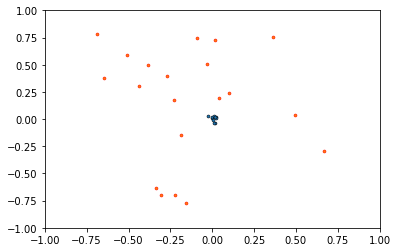

In [ ]:
anim = visualizer.animate_organism(graph, network, food=30, frames=100)
visualizer.save_animation_to_gif(anim, name, 10)

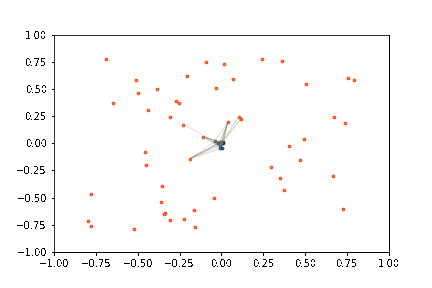

In [ ]:
Image('../animation/' + name + '.gif')

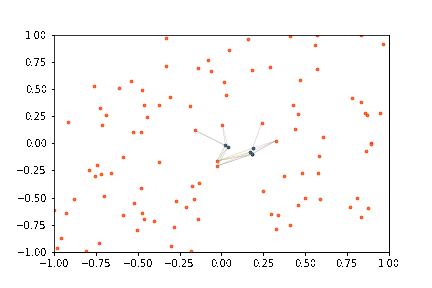

In [ ]:
Image('../animation/GATConv1.gif')

In [ ]:
anim.frame_seq = anim.new_saved_frame_seq() 
IPython.display.HTML(anim.to_jshtml())

In [ ]:
print(network)

CGConv1(
  (conv_layer_cells): CGConv(8, dim=4)
  (conv_layer_food): CGConv(8, dim=4)
  (mlp): Sequential(
    (0): ReLU()
    (1): Linear(in_features=16, out_features=16, bias=True)
    (2): ReLU()
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Linear(in_features=8, out_features=4, bias=True)
    (6): ReLU()
    (7): Linear(in_features=4, out_features=2, bias=True)
    (8): Tanh()
  )
  (mlp_before): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=8, bias=True)
    (3): ReLU()
  )
  (gConvGRU): GConvGRU(
    (conv_x_z): ChebConv(16, 16, K=1, normalization=sym)
    (conv_h_z): ChebConv(16, 16, K=1, normalization=sym)
    (conv_x_r): ChebConv(16, 16, K=1, normalization=sym)
    (conv_h_r): ChebConv(16, 16, K=1, normalization=sym)
    (conv_x_h): ChebConv(16, 16, K=1, normalization=sym)
    (conv_h_h): ChebConv(16, 16, K=1, normalization=sym)
  )
  (tanh): Tanh()
)


In [ ]:
print('conv_layers1: ', network.conv_layer_cells)
for param in network.conv_layer_cells.parameters():
  print(param.data)

print('conv_layers2: ', network.conv_layer_food)
for param in network.conv_layer_food.parameters():
  print(param.data)

conv_layers1:  CGConv(8, dim=4)
tensor([[ 0.0794, -0.3780,  0.2747, -0.1836,  0.5253,  0.0100, -0.2906,  1.3008,
         -0.5074, -0.2763,  0.0554,  0.0218, -0.6214, -0.5282, -0.6550, -1.0323,
         -0.0824,  0.2577, -0.5630, -0.6054],
        [-0.5018, -0.1512, -0.3038, -0.6904, -0.0988, -0.2788,  0.0340,  0.0809,
         -0.0106, -0.1766, -0.3423,  0.9103, -0.3626, -0.6281, -0.1750,  0.6885,
          0.1295, -0.4306,  0.8361,  0.9136],
        [-0.1622, -0.2573, -0.0178, -0.0704,  0.5464, -0.4442, -0.3942,  0.7053,
          0.2556, -0.0105,  0.5206,  0.1043,  0.6653, -0.1811,  0.0974, -0.2124,
          0.6834, -0.1547, -0.0739,  0.0200],
        [-0.7471,  0.0702,  0.3067,  0.3232,  0.7080, -0.0051,  0.3814, -0.1417,
          0.3855,  0.6523,  0.2077, -0.1174,  0.6873,  0.6962,  0.3374,  0.7166,
          0.2904, -0.5970,  1.2000, -0.0130],
        [-0.0271,  0.4907, -0.5476,  0.7145, -0.0808,  0.1607,  0.1215, -0.4800,
         -0.3603, -0.2998, -0.0961, -0.4051,  0.2399, -

In [ ]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

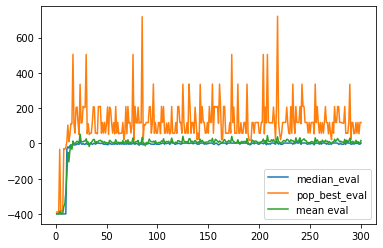

In [ ]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#plt.plot(losses.stepsize)
plt.plot(losses.median_eval)
plt.plot(losses.pop_best_eval)
plt.plot(losses.mean_eval)
plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()